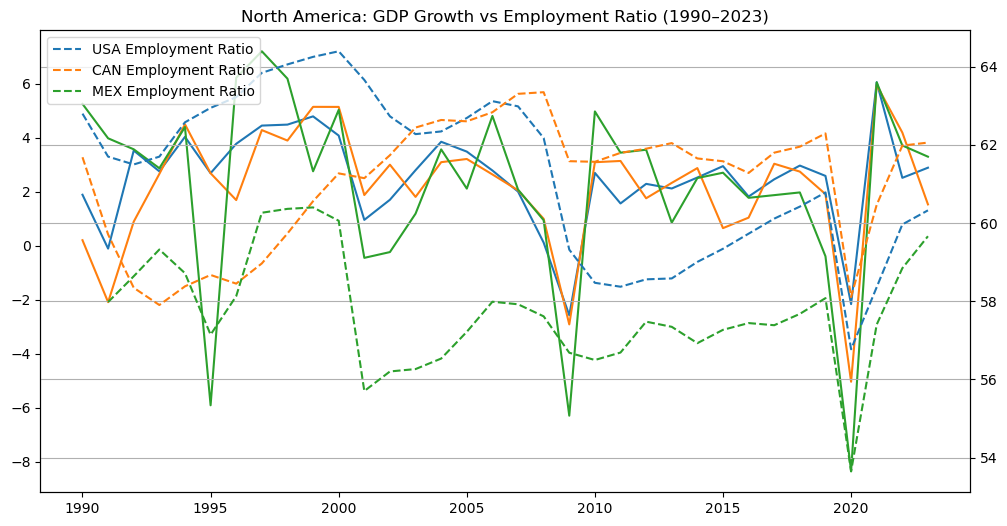

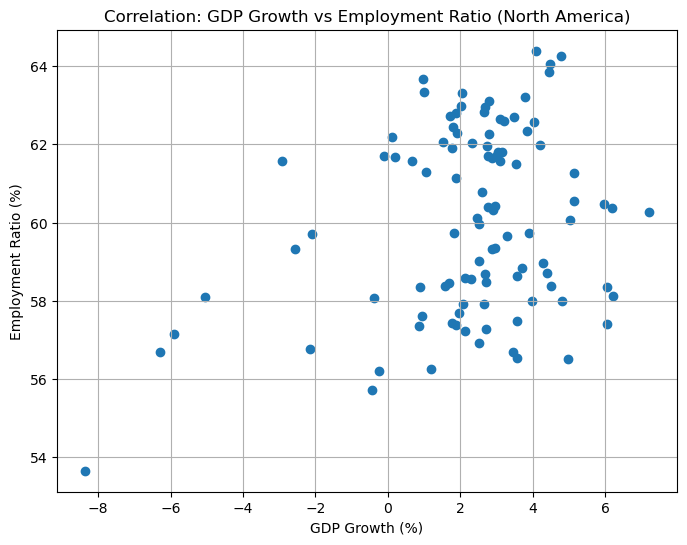

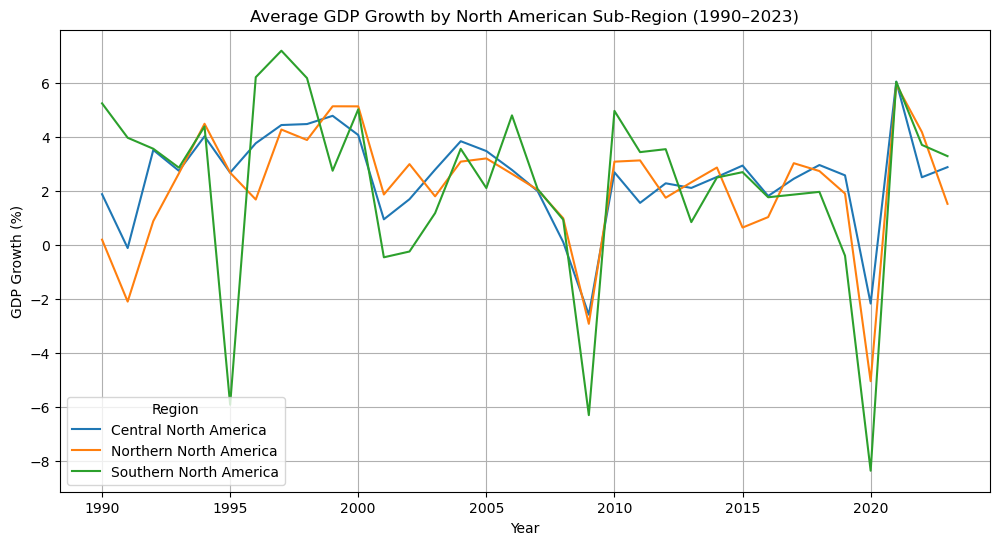

North America (all countries, all years)
Correlation (GDP vs Employment): 0.284
Regression: Employment ≈ 0.261 * GDP + 59.448


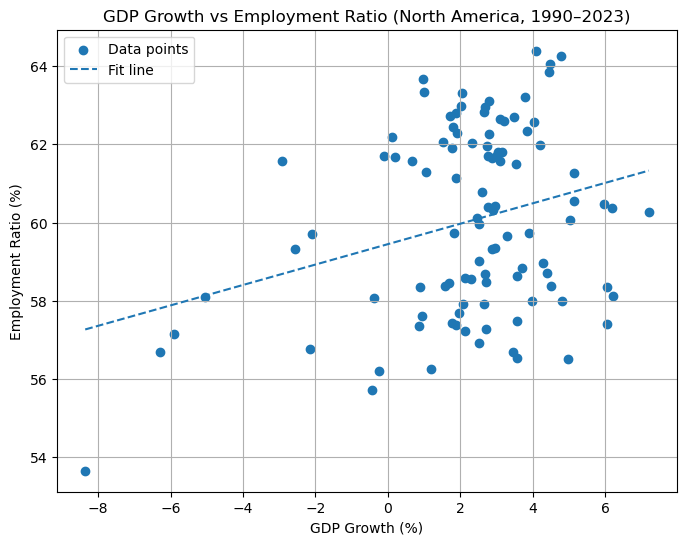


GDP Growth Summary by Region (1990–2023):
                        avg_gdp_growth  volatility (standard deviation)  \
region                                                                    
Central North America         2.491121                         1.757601   
Northern North America        2.174015                         2.223248   
Southern North America        2.270322                         3.468070   

                        worst_year  best_year  
region                                         
Central North America    -2.576500   6.055053  
Northern North America   -5.038233   5.950528  
Southern North America   -8.354035   7.198876  


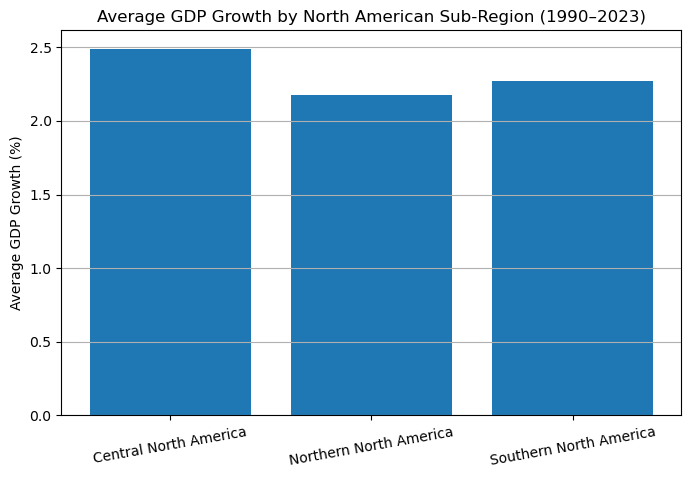

In [10]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import wbgapi as wb

DB = "north_america.db"

COUNTRIES = ["USA", "CAN", "MEX"]

GDP = "NY.GDP.MKTP.KD.ZG" 
EMP = "SL.EMP.TOTL.SP.NE.ZS"             

YEARS = list(range(1990, 2024))

REGION_MAP = {
    "CAN": "Northern North America",
    "USA": "Central North America",
    "MEX": "Southern North America"
}

rows = []

for c in COUNTRIES:

    gdp_bulk = list(wb.data.fetch(GDP, economy=c, time=YEARS))
    emp_bulk = list(wb.data.fetch(EMP, economy=c, time=YEARS))

    gdp_map = {}
    for item in gdp_bulk:
        year_str = item["time"]
        year = int(year_str[2:])        
        gdp_map[year] = item["value"]   

    emp_map = {}
    for item in emp_bulk:
        year_str = item["time"]
        year = int(year_str[2:])
        emp_map[year] = item["value"]

    for y in YEARS:
        rows.append({
            "country": c,
            "region": REGION_MAP[c],
            "year": y,
            "gdp_growth": gdp_map.get(y),
            "employment_ratio": emp_map.get(y)
        })

df = pd.DataFrame(rows)


with sqlite3.connect(DB) as conn:
    conn.execute("DROP TABLE IF EXISTS indicators")
    df.to_sql("indicators", conn, index=False)

# Load fresh
with sqlite3.connect(DB) as conn:
    df = pd.read_sql("SELECT * FROM indicators ORDER BY year", conn)

# 1: North American GDP vs Employment (USA, CAN, MEX)
plt.figure(figsize=(12,6))

for c in COUNTRIES:
    sub = df[df.country == c]
    plt.plot(sub.year, sub.gdp_growth, label=f"{c} GDP Growth")

plt.twinx()

for c in COUNTRIES:
    sub = df[df.country == c]
    plt.plot(sub.year, sub.employment_ratio, "--", label=f"{c} Employment Ratio")

plt.title("North America: GDP Growth vs Employment Ratio (1990–2023)")
plt.grid(True)
plt.legend(loc="upper left")
plt.show()

# 2: North American GDP vs Employment
plt.figure(figsize=(8,6))
plt.scatter(df.gdp_growth, df.employment_ratio)
plt.title("Correlation: GDP Growth vs Employment Ratio (North America)")
plt.xlabel("GDP Growth (%)")
plt.ylabel("Employment Ratio (%)")
plt.grid(True)
plt.show()

# 3: North American Sub-Region GDP Plot
plt.figure(figsize=(12,6))

regions = df.region.unique()

for region in regions:
    sub = df[df.region == region]
    avg_gdp = sub.groupby("year")["gdp_growth"].mean()

    plt.plot(avg_gdp.index, avg_gdp.values, label=region)

plt.title("Average GDP Growth by North American Sub-Region (1990–2023)")
plt.xlabel("Year")
plt.ylabel("GDP Growth (%)")
plt.grid(True)
plt.legend(title="Region")
plt.show()

# 4: All of North America Correlation + regression line

na = df.dropna(subset=["gdp_growth", "employment_ratio"])


corr = na["gdp_growth"].corr(na["employment_ratio"])

a, b = np.polyfit(na["gdp_growth"], na["employment_ratio"], 1)

print("North America (all countries, all years)")
print(f"Correlation (GDP vs Employment): {corr:.3f}")
print(f"Regression: Employment ≈ {a:.3f} * GDP + {b:.3f}")

plt.figure(figsize=(8,6))
plt.scatter(na["gdp_growth"], na["employment_ratio"], label="Data points")

x_vals = np.linspace(na["gdp_growth"].min(), na["gdp_growth"].max(), 100)
y_vals = a * x_vals + b
plt.plot(x_vals, y_vals, linestyle="--", label="Fit line")

plt.title("GDP Growth vs Employment Ratio (North America, 1990–2023)")
plt.xlabel("GDP Growth (%)")
plt.ylabel("Employment Ratio (%)")
plt.grid(True)
plt.legend()
plt.show()


# 5: Standard deviation of GDP growth by subregion

summary = (
    df.groupby("region")["gdp_growth"]
      .agg(["mean", "std", "min", "max"])
      .rename(columns={
          "mean": "avg_gdp_growth",
          "std": "volatility (standard deviation)",
          "min": "worst_year",
          "max": "best_year"
      })
)

print("\nGDP Growth Summary by Region (1990–2023):")
print(summary)

plt.figure(figsize=(8,5))
plt.bar(summary.index, summary["avg_gdp_growth"])
plt.title("Average GDP Growth by North American Sub-Region (1990–2023)")
plt.ylabel("Average GDP Growth (%)")
plt.xticks(rotation=10)
plt.grid(axis="y")
plt.show()
